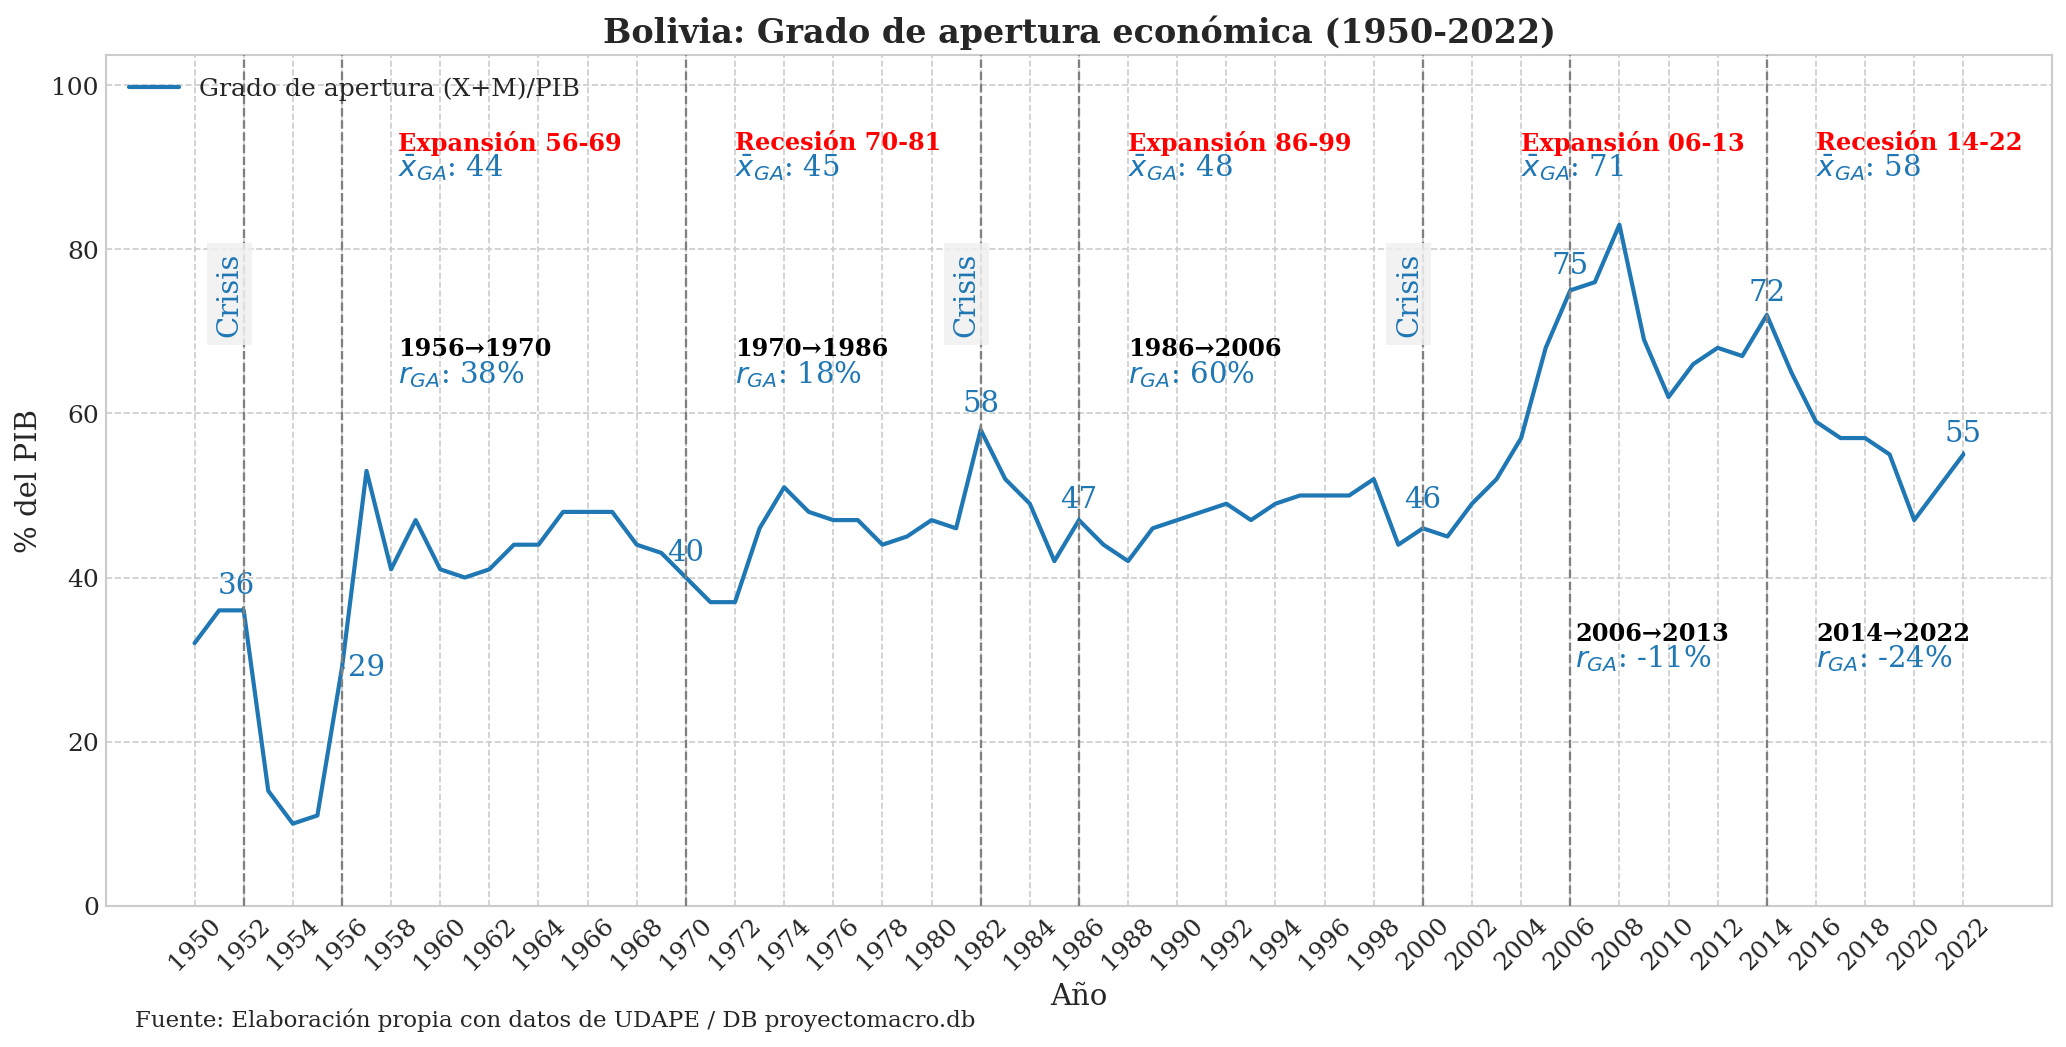

In [1]:
# ─────────────────── Grado de Apertura Económica 1950-2022 ───────────────────
import pandas as pd
import sys
import matplotlib.pyplot as plt
import sqlite3, os
sys.path.append(os.path.abspath('../'))
from graficos_utils import add_hitos, add_period_growth_annotations_multi, add_cycle_means_multi, add_year_value_annotations

# ── 0.  Tramos de ciclo (los mismos que usas en el resto de la tesis) ─────────
CRISIS_52_55      = slice(1952, 1955)   # Crisis
EXPANSION_56_69   = slice(1956, 1969)   # Expansión
RECESION_70_81    = slice(1970, 1981)   # Recesión
CRISIS_82_85      = slice(1982, 1985)   # Crisis (neoliberal)
EXPANSION_86_99   = slice(1986, 1999)   # Expansión
CRISIS_00_05      = slice(2000, 2005)   # Crisis
ACUMULACION_06_13 = slice(2006, 2013)   # Acumulación
RECESION_14_23    = slice(2014, 2023)   # Recesión   ← termina en 22 (2023 = preliminar)

periods = {
    "Expansión 56-69":   slice(1956, 1969),
    "Recesión 70-81":    slice(1970, 1981),
    "Expansión 86-99":   slice(1986, 1999),
    "Expansión 06-13": slice(2006, 2013),
    "Recesión 14-22":    slice(2014, 2022),
}

# ── 1. Configuración general de la figura y salida ───────────────────────────
output_dir = "../../../assets/tesis/serie_completa"
os.makedirs(output_dir, exist_ok=True)


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':  'serif',
    'font.size':    12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'figure.dpi':   150,
    'savefig.bbox': 'tight',
})

# ── 2. Carga de tabla grado_de_apertura ──────────────────────────────────────
db_path = '../../../db/proyectomacro.db'
query   = "SELECT * FROM grado_de_apertura"        # columnas: año, grado
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(query, conn, index_col='año')

df.sort_index(inplace=True)        # asegura orden cronológico
df.rename(columns={'grado': 'GA'}, inplace=True)   # más corto



# ── 3. Estadísticas por ciclo (medias) ───────────────────────────────────────
cycle_stats = {
    name: df.loc[period].mean().to_dict()
    for name, period in periods.items()
}
component_colors = {
    'GA': '#1f77b4'
}

# ── 4. Líneas verticales de hitos (mismos años que el gráfico de PIB) ───────
hitos_v = {
    1952: "Crisis",
    1956: "Expansión",
    1970: "Recesión",
    1982: "Crisis",
    1986: "Expansión",
    2000: "Crisis",
    2006: "Expansión",
    2014: "Recesión",
}
annotation_offsets = {
    "GA": {
        1952: (-0.3,  3.0),
        1956: ( 1.0,  0),
        1970: (0,  3.0),
        1982: ( 0,  3.2),
        1986: (0,  2.5),
        2000: ( 0,  3.5),
        2006: (0,  3.0),
        2014: ( 0,  2.8),
        2022: ( 0,  2.5),
    }
}

hitos_offset = {
    1952: 0.92, 1956: 0.50, 1970: 0.50,
    1982: 0.92, 1986: 0.50, 2000: 0.92,
    2006: 0.62, 2014: 0.48
}

tasas_offsets = {
    "1956-1970": (1958.3, 0.80),
    "1970-1986": (1972, 0.80),
    "1986-2006": (1988, 0.80),
    "2006-2013": (2006.2, 0.4),
    "2014-2022": (2016, 0.4),
}
means_offsets = {
    "Expansión 56-69": (1958.3,  1.09),
    "Recesión 70-81":  (1972, 1.09),
    "Expansión 86-99": (1988, 1.09),
    "Expansión 06-13": (2004,  1.09),
    "Recesión 14-22":  (2016,  1.09),
}
# ── 6. Graficar ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 7))

# Serie principal
ax.plot(df.index, df['GA'], color='tab:blue', label='Grado de apertura (X+M)/PIB')
y_max = ax.get_ylim()[1]
add_hitos(ax, df.index, hitos_v, hitos_offset)
#anotaciones de tasas
periodos = [
    (1956, 1970),
    (1970, 1986),
    (1986, 2006),
    (2006, 2013),
    (2014, 2022),
]
anot_years = [1952,1956,1970,1982,1986,2000,2006,2014,2022]
abbr_map = {
    "GA":"GA",
}
columnas=["GA"]
add_year_value_annotations(ax,df,anot_years,columnas,annotation_offsets,component_colors)
add_period_growth_annotations_multi(
    ax, df, periodos,
    columnas,
    tasas_offsets,
    component_colors,
    abbr_map,
)
add_cycle_means_multi(
    ax,
    cycle_stats,
    means_offsets,
    abbr_map,
    component_colors,
    line_spacing=y_max*0.03
)

# Etiquetas y formato
ax.set_title("Bolivia: Grado de apertura económica (1950-2022)", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("% del PIB")
ax.set_ylim(0, df['GA'].max()*1.25)
ax.set_xticks(range(1950, 2023, 2))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left')

fig.text(0.07, 0.01,
         "Fuente: Elaboración propia con datos de UDAPE / DB proyectomacro.db",
         ha='left', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "grado_apertura_1950_2022.png"))
plt.show()
